In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

In [2]:
model = sbm.PhaseNet(phases="PSN")

model.cuda();
print(model)

Component order:	ZNE
SeisBench model		PhaseNet

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
  (in_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1dSame(
    (conv): Conv1d(8, 11, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1dSame(
    (conv): Conv1d(11, 16, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1dSame(
    (conv): Conv1d(16, 22, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd3): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1dSame(
    (conv): Conv1d(22, 32, kernel_size=(7,), stride=(4,), padding=(3,))
  )
  (bnd4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up1): ConvTranspose1d(32, 22, kernel_size

for param in model.parameters():
    param.requires_grad = False
    print(param.requires_grad)

model.out.weight.requires_grad = True
model.up4.weight.requires_grad = True

for param in model.parameters():
    #param.requires_grad = False
    print(param.requires_grad)

In [3]:
data = sbd.Iquique(sampling_rate=100)
#data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()
data

2022-09-19 23:55:21,184 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


In [4]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[2];

{'X': (array([[198.29475309, 203.29475309, 210.29475309, ..., -28.70524691,
        -43.70524691, -61.70524691],
       [-67.81648663, -50.81648663, -49.81648663, ..., -91.81648663,
        -80.81648663, -66.81648663],
       [ 81.47247942,  66.47247942,  56.47247942, ..., -75.52752058,
        -55.52752058, -43.52752058]]), {'source_origin_time': '2014-05-01T00:52:20.970000Z', 'source_latitude_deg': -19.4527, 'source_longitude_deg': -69.9762, 'source_depth_km': 57.95, 'path_back_azimuth_deg': 329.936310182, 'station_network_code': 'DG', 'station_code': 'IN17', 'trace_channel': 'HH*', 'station_location_code': nan, 'station_latitude_deg': -20.48, 'station_longitude_deg': -69.35, 'station_elevation_m': 1278.0, 'trace_name': 'bucket0$2,:3,:15552', 'trace_sampling_rate_hz': 100, 'trace_completeness': 1.0, 'trace_has_spikes': False, 'trace_start_time': '2014-05-01T00:52:20.740000Z', 'trace_P_arrival_sample': 2000.0, 'trace_S_arrival_sample': 3551.0, 'trace_name_original': 'DG.IN17.', 'trace

In [5]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [6]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

In [7]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [8]:
learning_rate = 1e-2
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#loss_fn = torch.nn.CrossEntropyLoss()


def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h


In [9]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [10]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 1.639033  [    0/ 8040]
loss: 0.938360  [ 1280/ 8040]
loss: 0.601460  [ 2560/ 8040]
loss: 0.373657  [ 3840/ 8040]
loss: 0.262584  [ 5120/ 8040]
loss: 0.217113  [ 6400/ 8040]
loss: 0.197247  [ 7680/ 8040]
Test avg loss: 0.196275 

Epoch 2
-------------------------------
loss: 0.201585  [    0/ 8040]
loss: 0.194941  [ 1280/ 8040]
loss: 0.194255  [ 2560/ 8040]
loss: 0.192070  [ 3840/ 8040]
loss: 0.170122  [ 5120/ 8040]
loss: 0.161804  [ 6400/ 8040]
loss: 0.147397  [ 7680/ 8040]
Test avg loss: 0.143451 



In [11]:
'''
client = Client("ETH")
t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)
out = model.annotate(stream)
'''
import pandas as pd
import numpy as np
from data_preprocessing import Data_Preprocessing
from picks_comparison import Picks_Comparison

start_year_analysis = 2012
start_day_analysis = 182
end_year_analysis = 2012
end_day_analysis = 182
time_lag_threshold = 450
P_th = 0.3
S_th = 0.15

obj = Data_Preprocessing (start_year_analysis, start_day_analysis,
                    end_year_analysis, end_day_analysis)

stream = obj.get_waveforms_chile()
#client = Client("GFZ")

picks = model.classify(stream, batch_size=256, P_threshold=P_th, S_threshold=S_th, parallelism=1)

In [12]:


pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })

event_picks = pd.DataFrame(pick_df)



picks_obj = Picks_Comparison (start_year_analysis, 
            start_day_analysis,
            end_year_analysis,
            end_day_analysis, event_picks)

all_dists_p, all_dists_s = picks_obj()


/home/javak/Transfer-Deep-Learning-chile-subduction-zone/transfer_learning/picks_comparison.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S_picks[['station_code', 'others']] = df_S_picks['id'].str.split('.', 1, expand=True)
/home/javak/Transfer-Deep-Learning-chile-subduction-zone/transfer_learning/picks_comparison.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S_picks[['station_code', 'others']] = df_S_picks['id'].str.split('.', 1, expand=True)
/home/javak/Transfer-Deep-Learning-chile-s

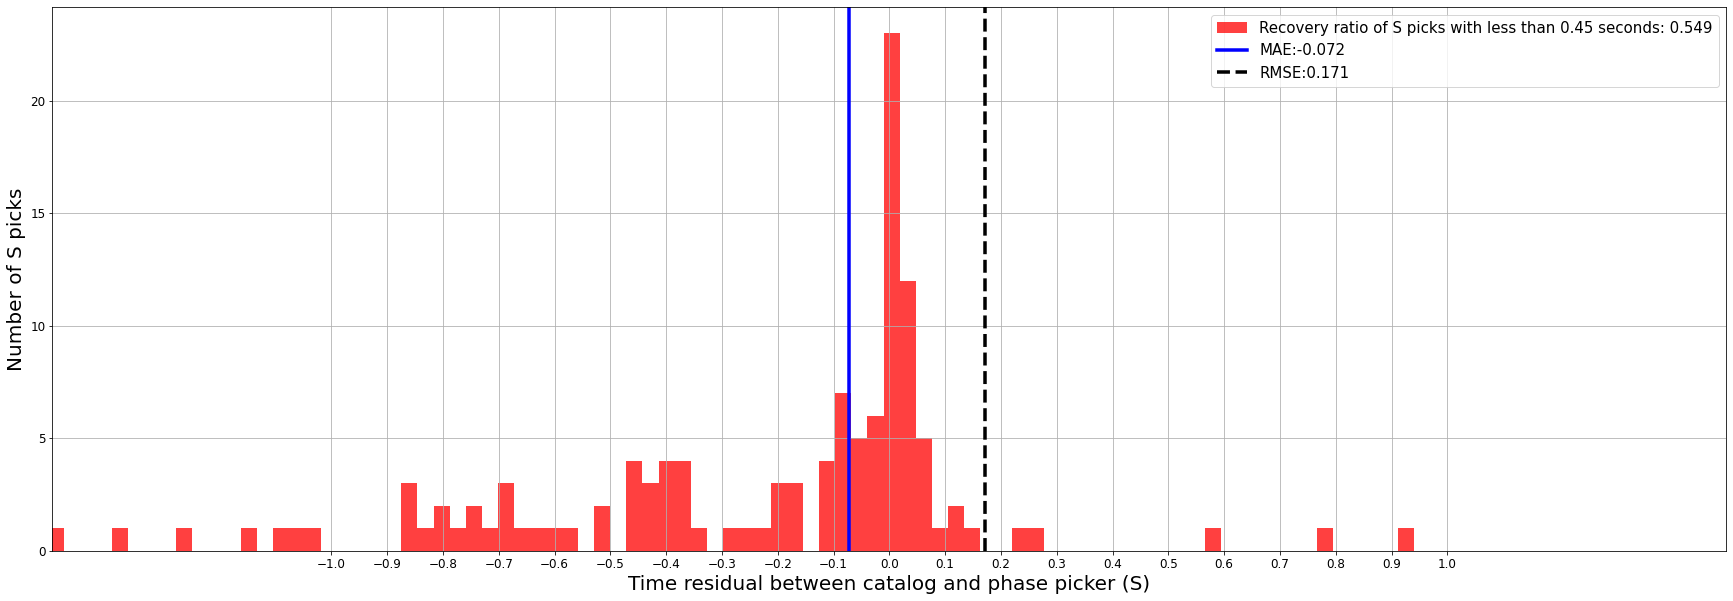

In [13]:
# Filter the time lag with the given threshold and capture the picks with more than .. second time lag
dists_filter_lag_time_m=all_dists_s[np.abs(all_dists_s) < 2000]/1000

# Perform S picks Quality control of PhaseNet by using existing S picks catalog with more than a given time lag
fig_lag_m, ax_lag_m = plt.subplots(figsize=(30,10))

label_more = '{0}{1}'.format('Recovery ratio of S picks with less than 0.45 seconds: ', round (all_dists_s[np.abs(all_dists_s) < time_lag_threshold].shape[0]/all_dists_s.shape[0],3))

n_lag_m, bins_lag_m, patches_lag_m = ax_lag_m.hist(dists_filter_lag_time_m, 100, density=False, facecolor='r', alpha=0.75, label=label_more)
#steps = (max(dists_filter_lag_time_m) - min(dists_filter_lag_time_m))/40
steps = 0.1
#plt.xticks(np.arange(min(dists_filter_lag_time_m), max(dists_filter_lag_time_m), step=steps))
plt.xticks(np.arange(-1, 1.1, step=steps))
plt.xlabel('Time residual between catalog and phase picker (S)', fontsize=20)
plt.ylabel('Number of S picks', fontsize=20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

filter_tim_lag = all_dists_s[np.abs(all_dists_s) < 450]/1000
MAE = np.sum(filter_tim_lag)/filter_tim_lag.shape[0]
RMSE = np.sqrt (np.sum(filter_tim_lag**2)/filter_tim_lag.shape[0])
plt.axvline(MAE, color='blue', label='MAE:'+str(round (MAE,3)),linewidth=3.5)
plt.axvline(RMSE, color='black', label='RMSE:'+str(round (RMSE,3)), linestyle="--", linewidth=3.5)

#plt.title('Common S picks distribution with less than 2 seconds time residual (2012-01-01 to 2012-12-31)', fontsize=24, pad=23)
#plt.xlim(min(bins_lag_m), max(bins_lag_m))
plt.xlim([-1.5,1.5])
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()



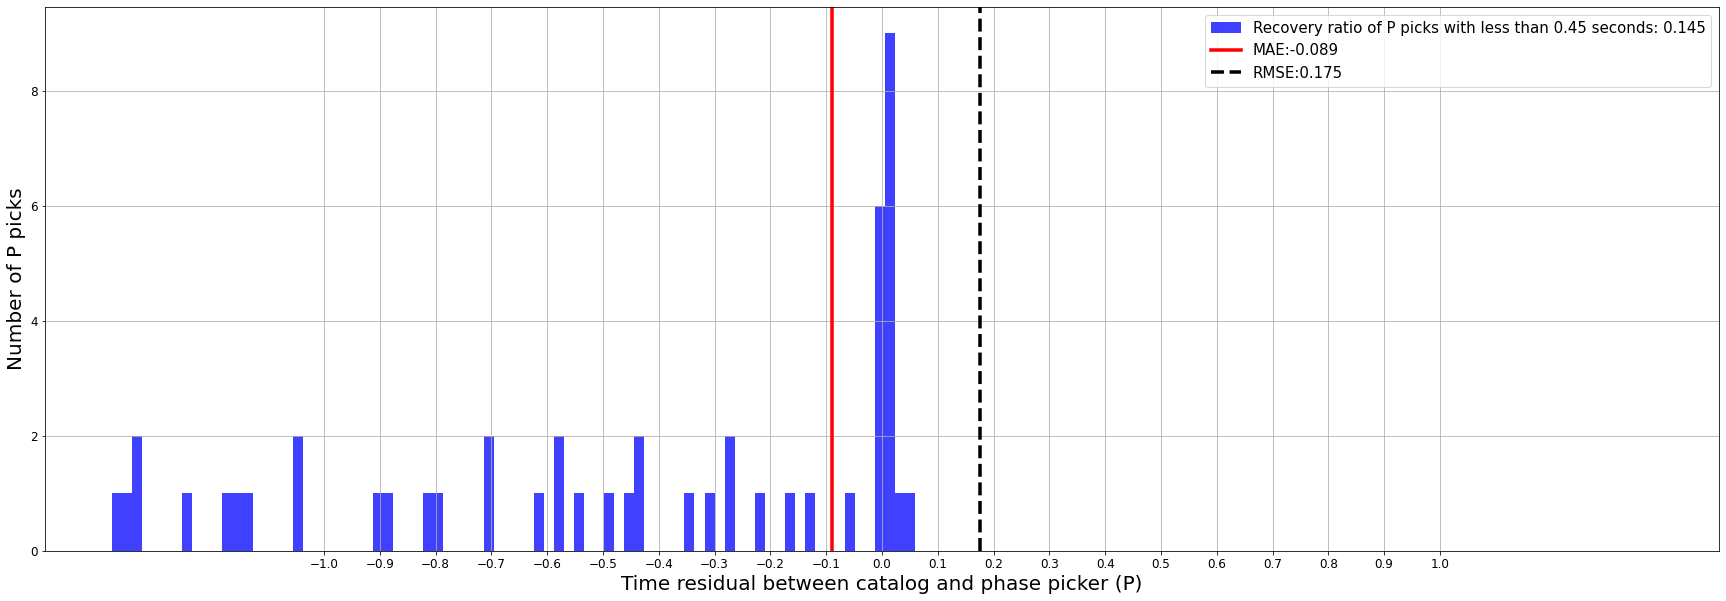

In [14]:
# Filter the time lag with the given threshold and capture the picks with more than .. second time lag
dists_filter_lag_time_m=all_dists_p[np.abs(all_dists_p) < 2000]/1000

# Perform S picks Quality control of PhaseNet by using existing S picks catalog with more than a given time lag
fig_lag_m, ax_lag_m = plt.subplots(figsize=(30,10))

label_more = '{0}{1}'.format('Recovery ratio of P picks with less than 0.45 seconds: ', round (all_dists_p[np.abs(all_dists_p) < time_lag_threshold].shape[0]/all_dists_p.shape[0],3))

n_lag_m, bins_lag_m, patches_lag_m = ax_lag_m.hist(dists_filter_lag_time_m, 100, density=False, facecolor='blue', alpha=0.75, label=label_more)
#steps = (max(dists_filter_lag_time_m) - min(dists_filter_lag_time_m))/40
steps = 0.1
#plt.xticks(np.arange(min(dists_filter_lag_time_m), max(dists_filter_lag_time_m), step=steps))
plt.xticks(np.arange(-1, 1.1, step=steps))
plt.xlabel('Time residual between catalog and phase picker (P)', fontsize=20)
plt.ylabel('Number of P picks', fontsize=20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

filter_tim_lag = all_dists_p[np.abs(all_dists_p) < 450]/1000
MAE = np.sum(filter_tim_lag)/filter_tim_lag.shape[0]
RMSE = np.sqrt (np.sum(filter_tim_lag**2)/filter_tim_lag.shape[0])
plt.axvline(MAE, color='r', label='MAE:'+str(round (MAE,3)),linewidth=3.5)
plt.axvline(RMSE, color='black', label='RMSE:'+str(round (RMSE,3)), linestyle="--", linewidth=3.5)

#plt.title('Common S picks distribution with less than 2 seconds time residual (2012-01-01 to 2012-12-31)', fontsize=24, pad=23)
#plt.xlim(min(bins_lag_m), max(bins_lag_m))
plt.xlim([-1.5,1.5])
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()

